https://medium.com/analytics-vidhya/principal-component-analysis-pca-part-1-fundamentals-and-applications-8a9fd9de7596  

https://www.geeksforgeeks.org/ml-face-recognition-using-pca-implementation/
https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/


In [1]:
# Import matplotlib library
import matplotlib.pyplot as plt

# Import scikit-learn library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import tensorflow as tf
import keras
from keras.utils import np_utils
from tensorflow.keras import datasets, layers, models

import numpy as np

In [2]:
# this command will download the LFW_people's dataset to hard disk.
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)
print(lfw_people.images.shape)
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# Instead of providing 2D data, X has data already in the form of a vector that
# is required in this approach.
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

(1288, 50, 37)
Number of Data Samples:  1288
Size of a data sample:  1850
Number of Class Labels:  7


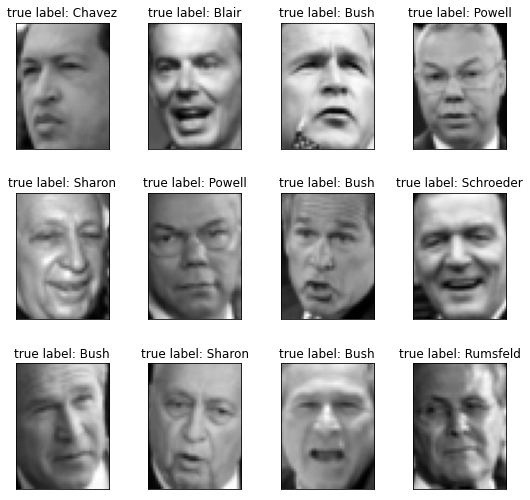

In [3]:
# Function to plot images in 3 * 4
def plot_gallery(images, titles, h, w, n_row = 3, n_col = 4):
	plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
	plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
	for i in range(n_row * n_col):
		plt.subplot(n_row, n_col, i + 1)
		plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
		plt.title(titles[i], size = 12)
		plt.xticks(())
		plt.yticks(())

# Generate true labels above the images
def true_title(Y, target_names, i):
	true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
	return 'true label: % s' % (true_name)

true_titles = [true_title(y, target_names, i)
					for i in range(y.shape[0])]
plot_gallery(X, true_titles, h, w)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size = 0.25, random_state = 42)
print("size of training Data is % d and Testing Data is % d" %(
		y_train.shape[0], y_test.shape[0]))

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

size of training Data is  966 and Testing Data is  322
(966, 1850) (322, 1850)
(966,) (322,)


In [5]:
n_components = 150

#t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
		whiten = True).fit(X_train)
#print("done in % 0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
#t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
#print("done in % 0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis


In [6]:
print("Sample Data point after applying PCA\n", X_train_pca[0])
print("-----------------------------------------------------")
print("Dimensions of training set = % s and Test Set = % s"%(
		X_train.shape, X_test.shape))

Sample Data point after applying PCA
 [-2.0756025  -1.0457913   2.1269355   0.0368267  -0.75757205 -0.5173633
  0.8555031   1.0519377   0.45774925  0.01347891 -0.03963304  0.63872755
  0.48166803  2.337881    1.7784227   0.13308963 -2.2713573  -4.456954
  2.0976138  -1.1379274   0.1884501  -0.33499128  1.1254514  -0.32403132
  0.14093933  1.0769513   0.7588204  -0.09977776  3.119963    0.8837758
 -0.8933952   1.159607    1.4306685   1.685633    1.3434894  -1.2590988
 -0.6391445  -2.3363414  -0.01365159 -1.4637516  -0.4688884  -1.0547512
 -1.3328867   1.1364055   2.2222369  -1.8017067  -0.30636144 -1.0282475
  4.773926    3.4595113   1.926101   -1.3519976  -0.25866663  2.010493
 -1.0562159   0.36058086  1.1702721   0.756956    0.90122426  0.5990687
 -0.46688792  2.0976236   1.3447547   1.93211     5.0683956  -0.70581347
  0.6059991  -0.9003078  -0.2165579  -2.1063826  -1.68157    -0.19863078
 -1.7477612  -3.0535786   2.0524232   0.38948283  0.1255674   1.2096993
 -0.7954547  -1.3963748 

In [7]:
print("Dimensions of training set after PCA = % s and Test Set = % s"%(
		X_train_pca.shape, X_test_pca.shape))

Dimensions of training set after PCA = (966, 150) and Test Set = (322, 150)


In [8]:
print("Fitting the classifier to the training set")
#t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
			'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
	SVC(kernel ='rbf', class_weight ='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
#print("done in % 0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Predicting people's names on the test set")
#t0 = time()
y_pred = clf.predict(X_test_pca)
#print("done in % 0.3fs" % (time() - t0))
# print classification results
print(classification_report(y_test, y_pred, target_names = target_names))
# print confusion matrix
print("Confusion Matrix is:")
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.84      0.59      0.70        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.87      0.70      0.76       322
     weighted avg       0.85      0.84      0.83       322

Confusion Matrix is:
[[  6   2   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  1   3  16   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.84      0.59      0.70        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       0.95      0.80      0.87        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.87      0.70      0.76       322
     weighted avg       0.85      0.84      0.83       322



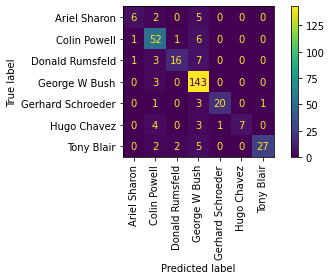

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
print("Predicting people's names on the test set")
#t0 = time()
y_pred = clf.predict(X_test_pca)
#print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

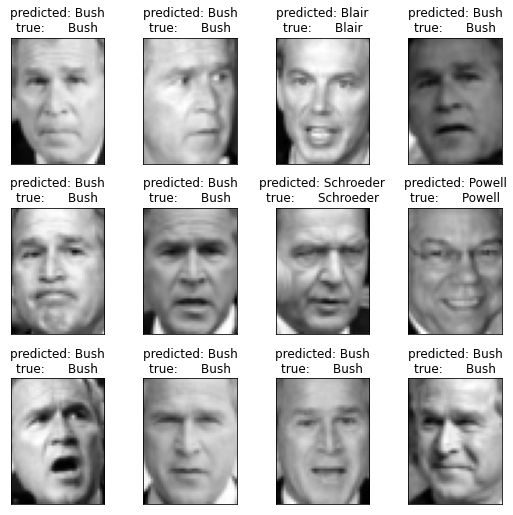

In [10]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
#plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)


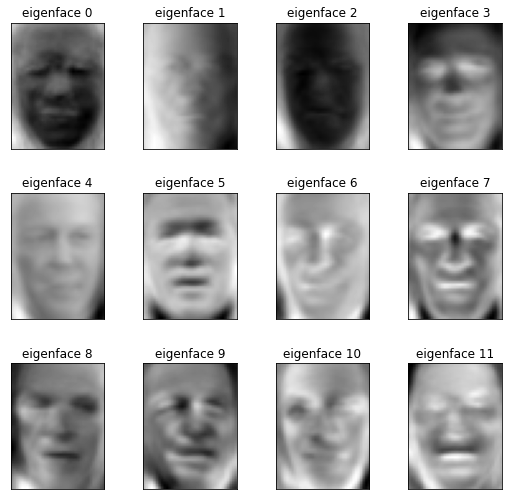

In [11]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Building a Neural network model with data without using PCA.

In [12]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [13]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [14]:
# Checking the number of unique classes 
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [15]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [16]:
x_train1 = train_images
x_test1 = test_images
y_train1 = train_labels
y_test1 = test_labels

In [17]:
x_train1 = train_images.astype('float32')
x_test1 = test_images.astype('float32')
x_train1 = x_train1 / 255.0
x_test1 = x_test1 / 255.0
y_train1 = np_utils.to_categorical(train_labels, 10)
y_test1 = np_utils.to_categorical(test_labels, 10)

In [18]:
y_train1.shape

(50000, 10)

In [19]:
nn = models.Sequential([
        layers.Flatten(input_shape=(32,32,3)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(2048, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

In [20]:
nn.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_3 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_4 (Dense)             (None, 10)                40970     
                                                                 
Total params: 12,631,562
Trainable params: 12,631,562
No

In [21]:
nn_model = nn.fit(x_train1, y_train1, validation_data=(x_test1, y_test1),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.9373 - accuracy: 0.2817 - val_loss: 1.7832 - val_accuracy: 0.3614
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7880 - accuracy: 0.3494 - val_loss: 1.7422 - val_accuracy: 0.3710
Epoch 3/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.7321 - accuracy: 0.3687 - val_loss: 1.6958 - val_accuracy: 0.3916
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6768 - accuracy: 0.3923 - val_loss: 1.6391 - val_accuracy: 0.4106
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6395 - accuracy: 0.4086 - val_loss: 1.6757 - val_accuracy: 0.3965
Epoch 6/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.6152 - accuracy: 0.4151 - val_loss: 1.5933 - val_accuracy: 0.4276
Epoch 7/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.5956 - accuracy: 0.4237 - val_loss: 1.6098 -

In [22]:
y_pred_nn = nn.predict(x_test1)
y_pred_classes = [np.argmax(element) for element in y_pred_nn]

y_test1=np.argmax(y_test1, axis=1)


print("Classification Report: \n", classification_report(y_test1, y_pred_classes))

pred_class_NN = np.argmax(y_pred_nn, axis=1)

Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.56      0.51      1000
           1       0.48      0.61      0.54      1000
           2       0.32      0.20      0.24      1000
           3       0.27      0.18      0.22      1000
           4       0.38      0.35      0.37      1000
           5       0.42      0.30      0.35      1000
           6       0.43      0.51      0.47      1000
           7       0.50      0.39      0.44      1000
           8       0.43      0.62      0.51      1000
           9       0.41      0.47      0.44      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



In [23]:
cm_NN = confusion_matrix(y_pred_classes, y_test1)
print(f"Confusion matrix for the Neural Network classifier:\n{cm_NN}")

Confusion matrix for the Neural Network classifier:
[[556  45 111  67  72  40  15  76 156  59]
 [ 60 614  52  67  33  47  35  49  82 249]
 [ 25  11 197  69 105  78  60  59   4   3]
 [ 22  15  66 181  48 143 109  60  16  20]
 [ 19  13 174  77 352  74  94 111   9   5]
 [ 10  11  66 175  34 302  45  54  16   7]
 [ 26  20 138 137 172 107 514  42   5  28]
 [ 33  22  72  41  89  57  40 386   6  28]
 [194  86  94  97  56  98  38  37 618 127]
 [ 55 163  30  89  39  54  50 126  88 474]]


Text(0.5, 1.0, 'Loss Curves')

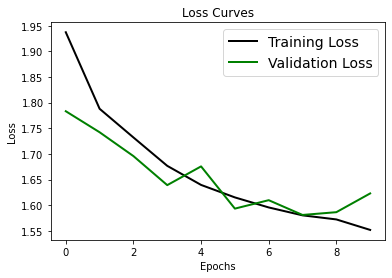

In [24]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['loss'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

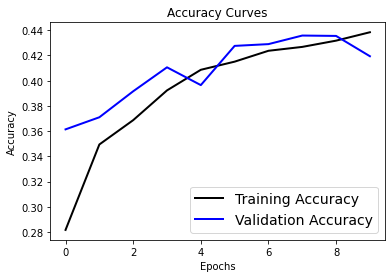

In [25]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['accuracy'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## Now applying PCA to the dataset, changing the input shape from 3072 to 150.

In [26]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [27]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [28]:
# Checking the number of unique classes 
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [29]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
x_train1 = train_images
x_test1 = test_images
y_train1 = train_labels
y_test1 = test_labels

In [31]:
x_train1 = train_images.astype('float32')
x_test1 = test_images.astype('float32')
x_train1 = x_train1 / 255.0
x_test1 = x_test1 / 255.0
y_train1 = np_utils.to_categorical(train_labels, 10)
y_test1 = np_utils.to_categorical(test_labels, 10)

In [32]:
x_train1=x_train1.reshape(x_train1.shape[0],x_train1.shape[1]*x_train1.shape[2]*x_train1.shape[3])
x_test1=x_test1.reshape(x_test1.shape[0],x_test1.shape[1]*x_test1.shape[2]*x_test1.shape[3])

In [33]:
n_components = 150

#t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
		whiten = True).fit(x_train1)
#print("done in % 0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, 32, 32,3))

print("Projecting the input data on the eigenfaces orthonormal basis")
#t0 = time()
X_train_pca = pca.transform(x_train1)
X_test_pca = pca.transform(x_test1)
print(X_train_pca.shape)

Projecting the input data on the eigenfaces orthonormal basis
(50000, 150)


In [34]:
print(X_test_pca.shape)

(10000, 150)


In [35]:
nn = models.Sequential([
        layers.Flatten(input_shape=(150,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(2048, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

In [36]:
nn.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               77312     
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dense_7 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_8 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_9 (Dense)             (None, 10)                40970     
                                                                 
Total params: 11,135,498
Trainable params: 11,135,498


In [37]:
nn_model = nn.fit(X_train_pca, y_train1, validation_data=(X_test_pca, y_test1),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 20s 12ms/step - loss: 1.6599 - accuracy: 0.3987 - val_loss: 1.4735 - val_accuracy: 0.4680
Epoch 2/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.3066 - accuracy: 0.5309 - val_loss: 1.4084 - val_accuracy: 0.5049
Epoch 3/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1171 - accuracy: 0.5981 - val_loss: 1.3534 - val_accuracy: 0.5230
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9525 - accuracy: 0.6565 - val_loss: 1.3817 - val_accuracy: 0.5271
Epoch 5/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8123 - accuracy: 0.7077 - val_loss: 1.4661 - val_accuracy: 0.5290
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.6848 - accuracy: 0.7531 - val_loss: 1.6345 - val_accuracy: 0.5243
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.5747 - accuracy: 0.7939 - val_loss: 1.7298 -

In [38]:
y_pred_nn_pca = nn.predict(X_test_pca)
y_pred_classes_pca = [np.argmax(element) for element in y_pred_nn_pca]

y_test1=np.argmax(y_test1, axis=1)

print("Classification Report: \n", classification_report(y_test1, y_pred_classes_pca))

pred_class_NN = np.argmax(y_pred_nn_pca, axis=1)

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.58      0.59      1000
           1       0.67      0.58      0.62      1000
           2       0.40      0.39      0.40      1000
           3       0.32      0.39      0.35      1000
           4       0.39      0.45      0.41      1000
           5       0.44      0.42      0.43      1000
           6       0.62      0.53      0.57      1000
           7       0.57      0.58      0.58      1000
           8       0.60      0.69      0.64      1000
           9       0.61      0.50      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.51     10000
weighted avg       0.52      0.51      0.51     10000



In [39]:
cm_NN = confusion_matrix(y_pred_classes_pca, y_test1)
print(f"Confusion matrix for the Neural Network classifier:\n{cm_NN}")

Confusion matrix for the Neural Network classifier:
[[580  42  80  23  42  12  15  21 101  48]
 [ 31 581  13  14   7   8  11   8  48 147]
 [ 48  19 393  88 165  77 109  40  17  25]
 [ 30  37 110 389  99 237 132  85  32  65]
 [ 40  23 165  97 446  91 110 135  31  19]
 [  9  13  75 202  50 417  69  84   9  28]
 [ 27  23  72  70  63  41 529  11   8  16]
 [ 32  23  62  56  99  79  10 583  16  59]
 [153  99  21  37  24  23   9  12 695  95]
 [ 50 140   9  24   5  15   6  21  43 498]]


Text(0.5, 1.0, 'Loss Curves')

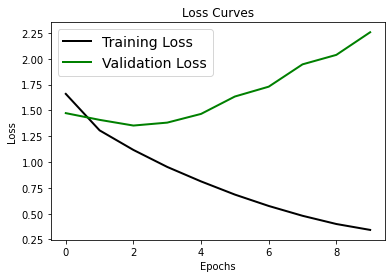

In [40]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['loss'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

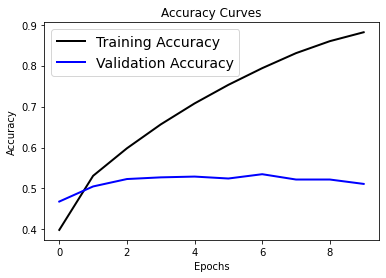

In [41]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['accuracy'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

## Now applying PCA to the dataset, changing the input shape from 3072 to 1500.

In [42]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [43]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [44]:
# Checking the number of unique classes 
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [45]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [46]:
x_train1 = train_images
x_test1 = test_images
y_train1 = train_labels
y_test1 = test_labels

In [47]:
x_train1 = train_images.astype('float32')
x_test1 = test_images.astype('float32')
x_train1 = x_train1 / 255.0
x_test1 = x_test1 / 255.0
y_train1 = np_utils.to_categorical(train_labels, 10)
y_test1 = np_utils.to_categorical(test_labels, 10)

In [48]:
x_train1=x_train1.reshape(x_train1.shape[0],x_train1.shape[1]*x_train1.shape[2]*x_train1.shape[3])
x_test1=x_test1.reshape(x_test1.shape[0],x_test1.shape[1]*x_test1.shape[2]*x_test1.shape[3])

In [49]:
n_components = 1500

#t0 = time()
pca = PCA(n_components = n_components, svd_solver ='randomized',
		whiten = True).fit(x_train1)
#print("done in % 0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, 32, 32,3))

print("Projecting the input data on the eigenfaces orthonormal basis")
#t0 = time()
X_train_pca = pca.transform(x_train1)
X_test_pca = pca.transform(x_test1)
print(X_train_pca.shape)

Projecting the input data on the eigenfaces orthonormal basis
(50000, 1500)


In [50]:
print(X_test_pca.shape)

(10000, 1500)


In [55]:
nn = models.Sequential([
        layers.Flatten(input_shape=(1500,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(2048, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

In [56]:
nn.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1500)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               768512    
                                                                 
 dense_16 (Dense)            (None, 1024)              525312    
                                                                 
 dense_17 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_18 (Dense)            (None, 4096)              8392704   
                                                                 
 dense_19 (Dense)            (None, 10)                40970     
                                                                 
Total params: 11,826,698
Trainable params: 11,826,698


In [57]:
nn_model = nn.fit(X_train_pca, y_train1, validation_data=(X_test_pca, y_test1),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 22s 13ms/step - loss: 1.9519 - accuracy: 0.2820 - val_loss: 1.7580 - val_accuracy: 0.3552
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5197 - accuracy: 0.4451 - val_loss: 1.6788 - val_accuracy: 0.4005
Epoch 3/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1925 - accuracy: 0.5610 - val_loss: 1.7187 - val_accuracy: 0.4145
Epoch 4/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8942 - accuracy: 0.6724 - val_loss: 1.9026 - val_accuracy: 0.4101
Epoch 5/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.6684 - accuracy: 0.7552 - val_loss: 2.1420 - val_accuracy: 0.4076
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 0.5086 - accuracy: 0.8159 - val_loss: 2.4032 - val_accuracy: 0.4023
Epoch 7/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.4045 - accuracy: 0.8586 - val_loss: 2.5037 -

In [58]:
y_pred_nn_pca = nn.predict(X_test_pca)
y_pred_classes_pca = [np.argmax(element) for element in y_pred_nn_pca]

y_test1=np.argmax(y_test1, axis=1)

print("Classification Report: \n", classification_report(y_test1, y_pred_classes_pca))

pred_class_NN = np.argmax(y_pred_nn_pca, axis=1)

Classification Report: 
               precision    recall  f1-score   support

           0       0.47      0.48      0.48      1000
           1       0.49      0.49      0.49      1000
           2       0.32      0.28      0.30      1000
           3       0.25      0.29      0.27      1000
           4       0.35      0.30      0.32      1000
           5       0.36      0.29      0.32      1000
           6       0.45      0.46      0.45      1000
           7       0.44      0.49      0.46      1000
           8       0.53      0.57      0.55      1000
           9       0.45      0.46      0.46      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000



In [59]:
cm_NN = confusion_matrix(y_pred_classes_pca, y_test1)
print(f"Confusion matrix for the Neural Network classifier:\n{cm_NN}")

Confusion matrix for the Neural Network classifier:
[[482  59  88  33  47  21  16  46 155  80]
 [ 42 492  28  46  19  18  40  35  79 212]
 [ 69  24 284 107 147  94  71  54  22  11]
 [ 56  46 118 291 111 240 160  59  37  48]
 [ 27  12 127  74 299  99 100  91  12  13]
 [ 10  19  85 153  69 290  57  97  14  18]
 [ 21  28 121 124 116  81 462  53   4  21]
 [ 36  38  80  82 150  97  47 488  22  76]
 [179  93  48  44  22  36  15  16 571  61]
 [ 78 189  21  46  20  24  32  61  84 460]]


Text(0.5, 1.0, 'Loss Curves')

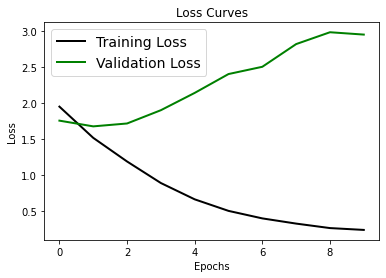

In [60]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['loss'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

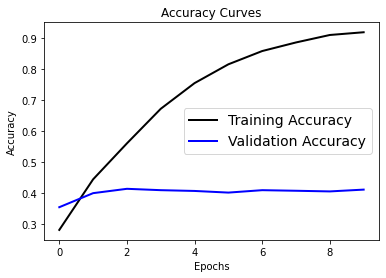

In [61]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(nn_model.history['accuracy'], 'black', linewidth=2.0)
plt.plot(nn_model.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html 